## Convnet practice with kidney dataset

In [70]:
# import cell
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import json


### Data Preparation

In [46]:
# seed setting and defaults for being good and clean
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [47]:
# setting up some ids for saving
model_id = "baseline_cnn"  # Or whatever naming scheme you want
model_save_path = f"models/{model_id}.weights.h5"

In [48]:
# split dataset into train, validate, test
ds_train, ds_validate = image_dataset_from_directory(r'../input/kaggle/ct-kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',
                                  labels='inferred',
                                  label_mode = 'categorical',
                                  color_mode = 'grayscale',
                                  image_size = (256, 256),
                                  shuffle = True,
                                  validation_split = 0.2,
                                  subset = 'both',
                                  seed = 314,
                                  batch_size = 16)
val_size = int(0.5 * tf.data.experimental.cardinality(ds_validate).numpy())

ds_val = ds_validate.take(val_size)
ds_test = ds_validate.skip(val_size)
ds_val.class_names = ds_validate.class_names
ds_test.class_names = ds_validate.class_names


Found 12446 files belonging to 4 classes.
Using 9957 files for training.
Using 2489 files for validation.


In [49]:
def get_class_distribution(dataset, class_names):
    label_counts = np.zeros(len(class_names), dtype=int)
    total = 0
    for _, labels in dataset:
        indices = tf.argmax(labels, axis=1).numpy()
        for i in indices:
            label_counts[i] += 1
            total += 1
    percent_distribution = {class_names[i]: round(100 * count / total, 2) for i, count in enumerate(label_counts)}
    return percent_distribution

print("Train class %:")
print(get_class_distribution(ds_train, ds_train.class_names))

Train class %:
{'Cyst': np.float64(29.72), 'Normal': np.float64(41.05), 'Stone': np.float64(11.12), 'Tumor': np.float64(18.12)}


### Model Declaration and Compiling

In [50]:
# Define augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation_layer")

model = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    data_augmentation,   
    layers.Conv2D(filters=32, kernel_size=5, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters = 64, kernel_size=3, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),
    # time for the head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=4, activation = 'softmax')
])

In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,676 (237.02 KB)

 Trainable params: 60,676 (237.02 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon=0.01),
    loss = 'categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

In [53]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.4981 - loss: 1.3913 - precision: 0.6078 - recall: 0.2804 - val_accuracy: 0.6282 - val_loss: 1.0272 - val_precision: 0.6962 - val_recall: 0.4591
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6300 - loss: 0.9917 - precision: 0.7276 - recall: 0.4754 - val_accuracy: 0.6402 - val_loss: 0.9128 - val_precision: 0.7041 - val_recall: 0.6082
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6500 - loss: 0.9299 - precision: 0.7467 - recall: 0.5273 - val_accuracy: 0.6330 - val_loss: 0.9499 - val_precision: 0.7237 - val_recall: 0.5561
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6537 - loss: 0.8992 - precision: 0.7509 - recall: 0.5289 - val_accuracy: 0.6426 - val_loss: 0.9543 - val_precision: 0.7296 - val_recall: 0.5729
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6576 - loss: 0.8753 - precision: 0.7565 - recall: 0.5396 - val_accuracy: 0.6522 - va

In [54]:
model.save_weights(model_save_path)

In [55]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=ds_test.class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025-05-09 17:44:52.288759: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

<Axes: >

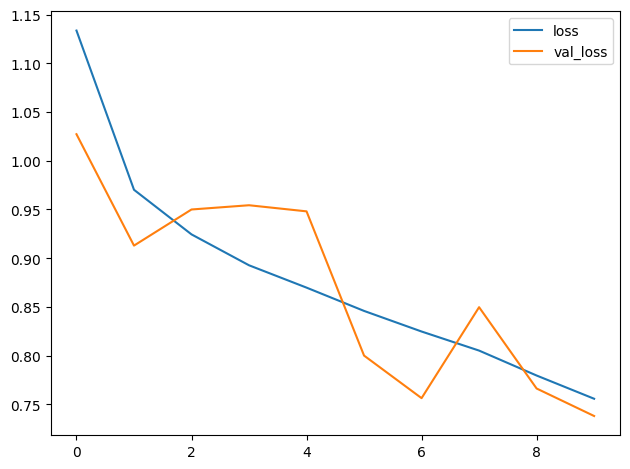

In [56]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

In [57]:
# time to examine kidney data issues.
df = pd.read_csv('../input/kaggle/ct-kidney/kidneyData.csv')

In [58]:
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [59]:
df.path[0]

'/content/data/CT KIDNEY DATASET Normal, CYST, TUMOR and STONE/TUMOR/Tumor- (1044).jpg'

In [60]:
print("Train class %:")
print(get_class_distribution(ds_test, ds_test.class_names))

Train class %:
{'Cyst': np.float64(31.91), 'Normal': np.float64(38.6), 'Stone': np.float64(9.83), 'Tumor': np.float64(19.66)}


In [61]:
preds = model.predict(ds_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [62]:
preds

array([[2.3380984e-03, 1.9280356e-01, 6.1148237e-03, 7.9874361e-01],
       [5.9282798e-02, 2.6308495e-01, 7.4621961e-02, 6.0301030e-01],
       [1.5408751e-11, 9.9789482e-01, 1.1802928e-03, 9.2492037e-04],
       ...,
       [7.1774727e-01, 1.2196159e-02, 2.5848797e-02, 2.4420772e-01],
       [1.9269462e-03, 2.4996682e-01, 6.3926177e-03, 7.4171364e-01],
       [8.9331017e-12, 9.9544805e-01, 4.3270756e-03, 2.2491181e-04]],
      dtype=float32)

In [63]:
y_pred = np.argmax(preds, axis=1)

In [64]:
y_true = []
for _, labels in ds_test:
    y_true.extend(tf.argmax(labels, axis=1).numpy())


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=ds_test.class_names))


              precision    recall  f1-score   support

        Cyst       0.72      0.96      0.82       396
      Normal       0.85      0.80      0.83       479
       Stone       1.00      0.02      0.03       122
       Tumor       0.50      0.53      0.51       244

    accuracy                           0.72      1241
   macro avg       0.77      0.58      0.55      1241
weighted avg       0.75      0.72      0.69      1241



In [66]:
for i in range(5):
    print(f"Predicted: {ds_test.class_names[y_pred[i]]}")
    print(f"Confidence: {np.max(preds[i]):.4f}")
    print(f"All probs: {preds[i]}")
    print("---")


Predicted: Tumor
Confidence: 0.7987
All probs: [0.0023381  0.19280356 0.00611482 0.7987436 ]
---
Predicted: Tumor
Confidence: 0.6030
All probs: [0.0592828  0.26308495 0.07462196 0.6030103 ]
---
Predicted: Normal
Confidence: 0.9979
All probs: [1.5408751e-11 9.9789482e-01 1.1802928e-03 9.2492037e-04]
---
Predicted: Cyst
Confidence: 0.6461
All probs: [0.6461092  0.01345644 0.03347386 0.30696046]
---
Predicted: Cyst
Confidence: 0.7525
All probs: [0.7524564  0.01079481 0.01841958 0.21832915]
---


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


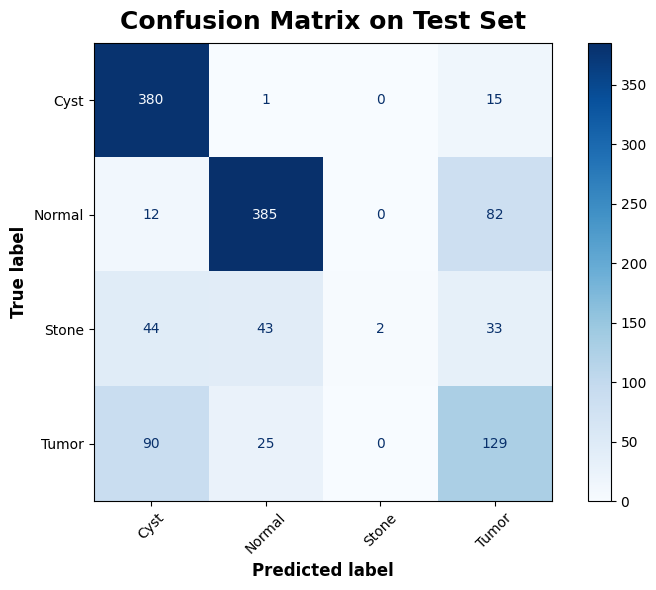

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# First get predictions and true labels (you’ve likely already done this)
y_pred = np.argmax(model.predict(ds_test), axis=1)
y_true = []
for _, labels in ds_test:
    y_true.extend(tf.argmax(labels, axis=1).numpy())

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ds_test.class_names)

# Plot it
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [68]:

# Convert Keras history to DataFrame
hist_df = pd.DataFrame(history.history)

# Save to CSV
hist_df.to_csv(f"logs/{model_id}_history.csv", index=False)

In [71]:
report = classification_report(y_true, y_pred, target_names=ds_test.class_names, output_dict=True)

with open(f"logs/{model_id}_classification_report.json", "w") as f:
    json.dump(report, f, indent=4)


with open(f"logs/{model_id}_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
